In [1]:
import cv2
import numpy
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision.utils import make_grid
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [145]:
def mouth_extractor(file_path: str, scale_factor=1.3, min_neighbors=5, mouth_size=(140, 70)) -> None:
    """
    Extract the mouth from the video and save as an npy file
    :param file_path: Path to the video file
    :param scale_factor: Parameter specifying how much the image size is reduced at each image scale
    :param min_neighbors: Parameter specifying how many neighbors each candidate rectangle should have to retain it
    :param mouth_size: Size of the extracted mouth region
    :return: None
    """
    base_path = file_path.split('.')[0]
    # if not os.path.exists(base_path + '.npy'):
    if file_path.endswith('.mpg'):
        cap = cv2.VideoCapture(file_path)
        if not cap.isOpened():
            raise Exception("Error: Could not open video.")

        frames = []
        for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
            ret, frame = cap.read()
            if not ret:
                raise Exception("Error: Could not read frame.")
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
            faces = face_cascade.detectMultiScale(gray, scale_factor, min_neighbors)
            for (x, y, w, h) in faces:
                mouth_roi = frame[y + int(h / 2):y + h, x:x + w]
                mouth_roi = cv2.resize(mouth_roi, mouth_size)
                mouth_roi = cv2.cvtColor(mouth_roi, cv2.COLOR_BGR2GRAY)
                frames.append(mouth_roi)

        cap.release()
        
        # Normalize frames
        frames = np.array(frames)
        mean = np.mean(frames)
        std = np.std(frames)
        frames_tensor = (frames - mean) / std
        frames_tensor = np.expand_dims(frames_tensor, axis=1)
        # Save as npy file
       
        np.save(base_path + '.npy', frames_tensor)
        return frames_tensor
    else:
        raise Exception("Error: File format not supported.")

(75, 1, 70, 140)


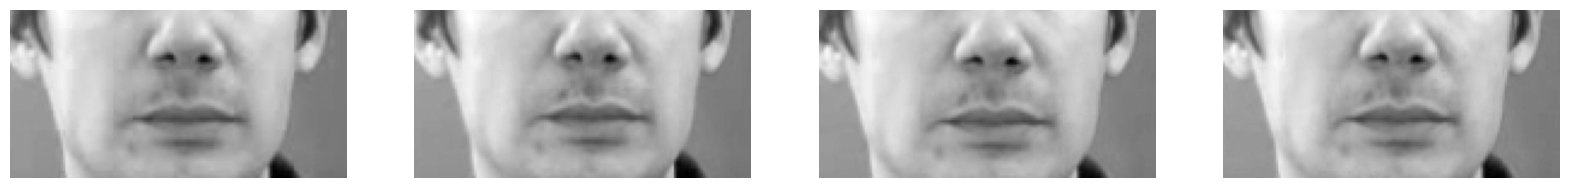

In [144]:
frames_tensor=mouth_extractor('/home/liazylee/jobs/python/AI/lip_reading/src/lipNet/data/s1/bbbmzn.mpg')
print(frames_tensor.shape)
# show the first 10 frames the np shape is (75, 1, 70, 140)
fig, ax = plt.subplots(1, 4, figsize=(20, 10))
for i in range(4):
    ax[i].imshow(frames_tensor[i].squeeze(0), cmap='gray')
    ax[i].axis('off') # no axes for this plot




In [97]:
print(frames_tensor.shape)

(75, 70, 140, 1)


[[-0.3514759  -1.07981543 -1.46132661 ... -1.01044976 -1.01044976
  -0.94108409]
 [-0.3514759  -1.07981543 -1.49600945 ... -1.01044976 -1.01044976
  -0.94108409]
 [-0.42084157 -1.18386393 -1.56537512 ... -0.97576692 -0.97576692
  -0.97576692]
 ...
 [-0.38615873 -0.42084157 -0.42084157 ... -1.18386393 -1.18386393
  -1.18386393]
 [-0.38615873 -0.42084157 -0.42084157 ... -1.18386393 -1.18386393
  -1.18386393]
 [-0.38615873 -0.4555244  -0.4555244  ... -1.21854677 -1.21854677
  -1.21854677]]


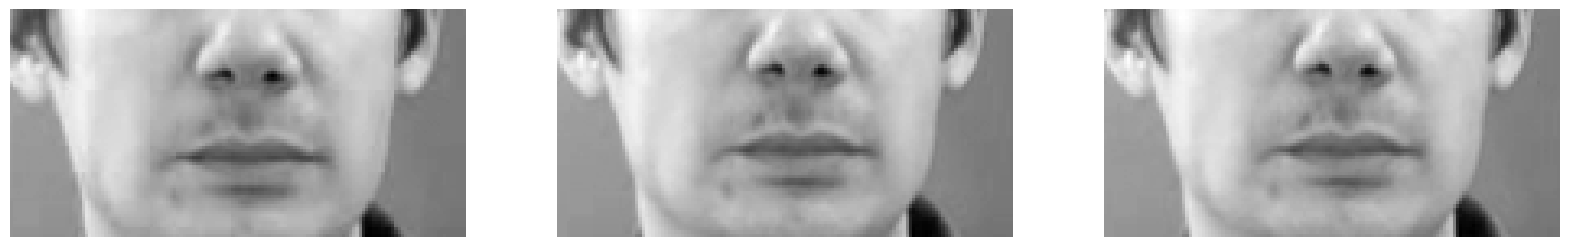

In [56]:
frames_tensor=mouth_extractor('../data/s1/bbbmzn.mpg')
# show the first 10 frames
fig, ax = plt.subplots(1, 3, figsize=(20, 10))
for i in range(3):
    ax[i].imshow(frames_tensor[i], cmap='gray')
    ax[i].axis('off') # no axes for this plot
plt.show()

In [146]:
np.load('/home/liazylee/jobs/python/AI/lip_reading/src/lipNet/data/s1/bbbmzn.npy').shape

(75, 1, 70, 140)

In [158]:
import logging
import os
import glob
from typing import List, Tuple
import numpy as np
import torch
def load_data(dir)->List[Tuple[torch.Tensor, torch.Tensor]]:
    data = []
    # 递归搜索该目录下的文件含有align的文件
    alignments = glob.glob(dir + '/**/*.align', recursive=True)
    alignments_dict={}
    for align in alignments:
        alignments_dict[align.split('/')[-1].split('.')[0]]=load_alignments(align)
    for root,dir,files in os.walk(dir):
        for file in files:
            if file.endswith('.npy'):
                video_frames = np.load(os.path.join(root,file))
                video_frames=torch.from_numpy(video_frames).float()
                filename = file.split('.')[0]
                if filename in alignments_dict:
                    alignments = alignments_dict[filename]
                else:
                    logging.warning(f'No alignment found for {filename}')
                    alignments = ''
                data.append((video_frames,alignments))
    return data
def load_alignments(path:str)->torch.Tensor:
    with open (path,'r') as f:
        lines = f.readlines()
        tokens = ''
        for line in lines:
            line = line.split()
            if line[2] != 'sil': 
                tokens = tokens + ' ' + line[2]
        tokens_np=np.array([ord(c) for c in tokens])
        tokens_tensor=torch.from_numpy(tokens_np).float()
        return tokens_tensor

In [100]:
data=load_data('/home/liazylee/jobs/python/AI/lip_reading/src/lipNet/data/')
print(data[0][0].shape)

torch.Size([75, 70, 140])


In [101]:
print(data[0][1].shape)

torch.Size([22])


In [177]:
def pretain(dir:str)->List:
    """
    find all the video and extra the mouth region 
    :param dir: 
    :return: 
    """
    video_list=glob.glob(dir+'/**/*.mpg',recursive=True)
    return video_list
    

In [178]:
video_list=pretain('/home/liazylee/jobs/python/AI/lip_reading/src/lipNet/data')


In [179]:
print(video_list[:100])

['/home/liazylee/jobs/python/AI/lip_reading/src/lipNet/data/s10/pgbn9a.mpg', '/home/liazylee/jobs/python/AI/lip_reading/src/lipNet/data/s10/lgbi9s.mpg', '/home/liazylee/jobs/python/AI/lip_reading/src/lipNet/data/s10/pgwo2p.mpg', '/home/liazylee/jobs/python/AI/lip_reading/src/lipNet/data/s10/sgbz9s.mpg', '/home/liazylee/jobs/python/AI/lip_reading/src/lipNet/data/s10/swaz1a.mpg', '/home/liazylee/jobs/python/AI/lip_reading/src/lipNet/data/s10/swar7a.mpg', '/home/liazylee/jobs/python/AI/lip_reading/src/lipNet/data/s10/bbaczp.mpg', '/home/liazylee/jobs/python/AI/lip_reading/src/lipNet/data/s10/brbp9a.mpg', '/home/liazylee/jobs/python/AI/lip_reading/src/lipNet/data/s10/bgbe2p.mpg', '/home/liazylee/jobs/python/AI/lip_reading/src/lipNet/data/s10/sgbmzn.mpg', '/home/liazylee/jobs/python/AI/lip_reading/src/lipNet/data/s10/swie3s.mpg', '/home/liazylee/jobs/python/AI/lip_reading/src/lipNet/data/s10/bgwy6n.mpg', '/home/liazylee/jobs/python/AI/lip_reading/src/lipNet/data/s10/pwwn7a.mpg', '/home/liaz

In [180]:

for i in range(100):
    mouth_extractor(video_list[i])


In [198]:
from src.lipNet.pytorch_lipNet.config import DIR
from src.lipNet.pytorch_lipNet.dataset import LRNetDataset
from torch.nn.utils.rnn import pad_sequence

def load_train_test_data()->Tuple[torch.utils.data.Subset, torch.utils.data.Subset]:
    video_dataset = LRNetDataset(DIR)
    train_size = int(0.8 * len(video_dataset))
    test_size = len(video_dataset) - train_size
    return torch.utils.data.random_split(video_dataset, [train_size, test_size])
def collate_fn(batch):
    inputs, targets = zip(*batch)
    padded_inputs = pad_sequence(inputs, batch_first=True, padding_value=0)
    padded_targets = pad_sequence(targets, batch_first=True, padding_value=0)
    return padded_inputs, padded_targets,


In [202]:
from torch.utils.data import DataLoader

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_dataset, val_dataset = load_train_test_data()
train_loader = DataLoader(train_dataset,collate_fn=collate_fn, batch_size=32, shuffle=True)

In [203]:
sample_inputs, *args= next(iter(train_loader)) 


In [205]:
input_shape = sample_inputs.shape

print(input_shape)
print(list(map(lambda x: x.shape, args)))

torch.Size([32, 75, 1, 70, 140])
[torch.Size([32, 33])]


In [206]:
input_channels = input_shape[1]
print(input_channels)

75


In [207]:
from model import LRModel
from torch import nn, optim
model = LRModel().to(device)
criterion = nn.CTCLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_loss_curve,val_loss_curve,train_wer_curve,val_wer_curve = [],[],[],[]

In [211]:
for epoch in range(10):
    train_loss = 0
    val_loss = 0
    train_wer = 0
    val_wer = 0
    for i, (inputs, targets) in enumerate(train_loader):
        #[32, 75, 1, 70, 140]->[32,1,75,70,140]
        inputs=torch.permute(inputs,(0,2,1,3,4))
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        input_lengths = torch.full(size=(outputs.size(1),), fill_value=outputs.size(0), dtype=torch.long)
        target_lengths = torch.full(size=(targets.size(0),), fill_value=targets.size(1), dtype=torch.long)
        loss = criterion(outputs, targets, input_lengths, target_lengths)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        if i % 10 == 0:
            print(f'Epoch {epoch + 1}/{10}, Step {i}/{len(train_loader)}, Loss: {loss.item():.4f}')
    train_loss /= len(train_loader)
    train_loss_curve.append(train_loss)

Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 239, in _feed
    reader_close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/home/liazylee/jobs/venv_python/lip_reading/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 271, in _feed
    queue_sem.release()
ValueError: semaphore or lock 

OutOfMemoryError: CUDA out of memory. Tried to allocate 11.22 GiB. GPU 0 has a total capacity of 15.67 GiB of which 2.88 GiB is free. Including non-PyTorch memory, this process has 11.78 GiB memory in use. Of the allocated memory 11.49 GiB is allocated by PyTorch, and 28.93 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)